В папке `/kaggle/input/sf-captcha-recognition` содержатся данные соревнования. Посмотрим, какие файлы там есть.

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-captcha-recognition/sample_submission.csv
/kaggle/input/sf-captcha-recognition/data/images_unlabeled.npy
/kaggle/input/sf-captcha-recognition/data/images.npy
/kaggle/input/sf-captcha-recognition/data/labels.npy
/kaggle/input/sf-captcha-recognition/data/images_sub.npy


Let's load the data into numpy arrays.

In [2]:
import numpy as np
images = np.load('/kaggle/input/sf-captcha-recognition/data/images.npy')
labels = np.load('/kaggle/input/sf-captcha-recognition/data/labels.npy')
images_sub = np.load('/kaggle/input/sf-captcha-recognition/data/images_sub.npy')
print(f'images: {images.shape} of type {images.dtype}')
print(f'labels: {labels.shape} of type {labels.dtype}')
print(f'images_sub: {images_sub.shape} of type {images_sub.dtype}')

num_classes = 26
img_shape = (48, 48, 3) 

images: (20000, 48, 48, 3) of type uint8
labels: (20000,) of type int64
images_sub: (50000, 48, 48, 3) of type uint8


Let's see what the images look like.

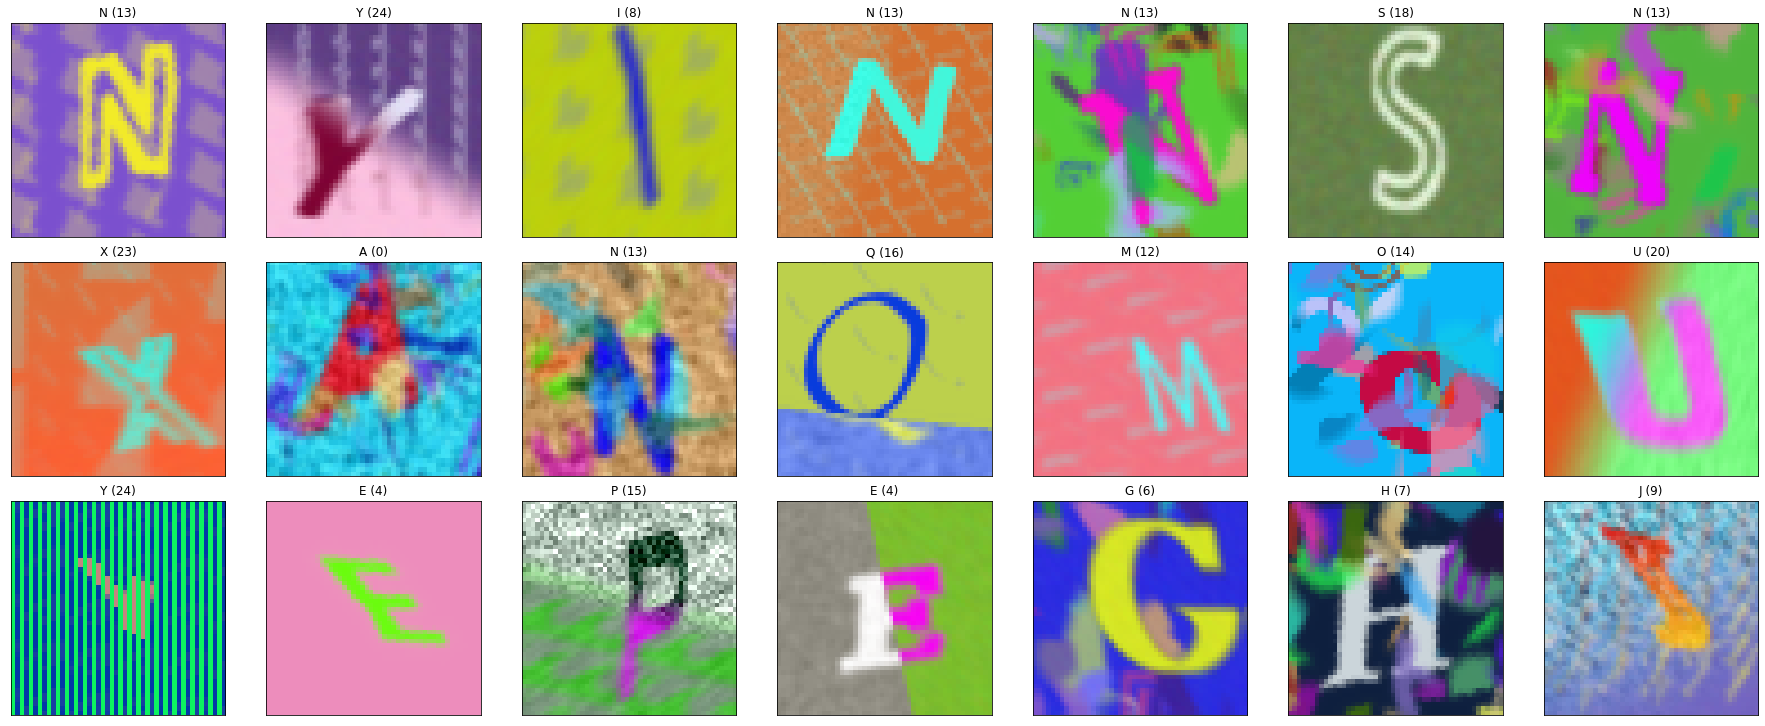

In [3]:
import matplotlib.pyplot as plt

def label_to_letter(label):
    return chr(ord('A') + label)

def show_symbols(images, labels = None, columns = 10, **kwargs):
    if labels is None: labels = [None] * len(images)
    rows = (len(images) - 1) // columns + 1
    fig = plt.figure(figsize = (25, (1.8 * 13 / columns) * rows))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = fig.add_subplot(rows, columns, i + 1)
        imshow_kwargs = {'vmin': 0, 'vmax': 255}
        imshow_kwargs.update(kwargs)
        ax.imshow(img, **imshow_kwargs)
        if label is not None: ax.set_title(label)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    fig.tight_layout(pad = 0.5)
    plt.show()

display_count = 7*3
show_symbols(
    images[:display_count],
    labels = [f'{label_to_letter(x)} ({x})' for x in labels[:display_count]],
    columns = 7
)

Let's see how the classes are distributed in the training data, and also calculate the probability of randomly guessing the class.

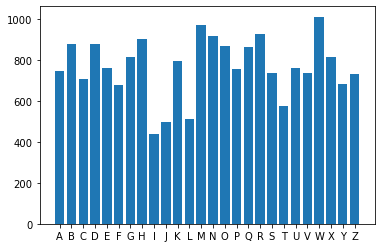

Вероятность случайного угадывания: 0.0385


In [4]:
import string
plt.bar(x = list(string.ascii_uppercase), height = np.bincount(labels));
plt.show()

print(f'Probability of random guessing: {1/num_classes:.4f}')

Let's not forget to normalize the images, that is, convert pixels from the range from 0 to 255 to the range from 0 to 1 by dividing the array by 255. There is another normalization option - conversion to the range from -1 to 1 (division by 128 and subtraction of one).

In [5]:
images_normalized = images / 255
images_sub_normalized = images_sub / 255

Now let's train the MLP model, that is, a fully connected network, and evaluate its accuracy.

In [6]:
import keras 
from IPython.display import clear_output

model = keras.Sequential([
    keras.Input(shape = img_shape), # img_shape == (48, 48, 3)
    # the Dense layer takes a one-dimensional vector, and the image is three-dimensional,
    #therefore, we use the Flatten layer to translate into a 1-dimensional vector
    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'sigmoid'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = keras.optimizers.Adam(1e-5),
    metrics = 'accuracy'
)

Let's start training the model. Don't forget to turn on the GPU in the laptop settings so that learning goes faster (Accelerator -> GPU).

Note that the `loss`, `optimizer`, `metric` parameters in the `model.compiler()` function, as well as the `activation` parameter in the `Dance` layer can be set as strings or classes.

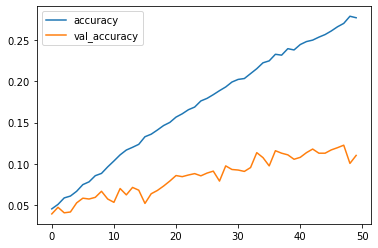

In [7]:
for epoch in range(50): 
    history = model.fit(
        #training data - input (normalized images) and target (class labels)
        images_normalized, labels,
        batch_size = 8,
        # we do not manually divide the data into training and validation, with the parameter
        # validation_split the .fit() method does it for us
        validation_split = 0.15,
        # we teach one epoch at a time (see external cycle)
        epochs = 1,
        # this parameter is needed so that metrics are saved during training
        callbacks = ([model.history] if epoch > 0 else None)
    )
    # after each epoch, we clear the cell output and redraw the accuracy graph
    clear_output(wait = True)
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.show()

The graph of the training accuracy of a fully connected network is far ahead of the validation accuracy - this means that the model has been retrained. The accuracy on validation barely exceeds 10%, which is not much, but much higher than the accuracy of random guessing.

Now let's train a simple convolutional network and see the difference. In the future, by studying the course material, you will be able to further improve accuracy.

In [8]:
model = keras.Sequential([
    keras.Input(shape = img_shape),
    keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = keras.optimizers.Adam(1e-4),
    metrics = 'accuracy'
)

We will train a convolutional network for 20 epochs as an example, although more epochs would give even higher accuracy.

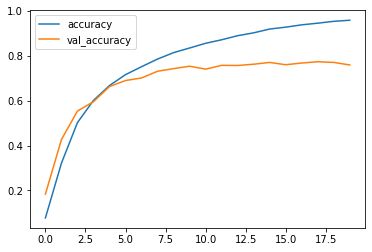

In [9]:
for epoch in range(20):
    history = model.fit(
        images_normalized, labels,
        batch_size = 8,
        validation_split = 0.15,
        epochs = 1,
        callbacks = ([model.history] if epoch > 0 else None)
    )
    clear_output(wait = True)
    plt.plot(history.history['accuracy'], label = 'accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.show()

Now let's make convolutional network predictions on normalized sumbission data.

In [10]:
predictions = model.predict(images_sub_normalized)
print(predictions.shape)

(50000, 26)


The first axis is the image number, the second is the class number, the values in the array are probabilities. It remains for us to find the class for each image, the probability for which is the greatest, for this we use the `argmax` method for axis 1.

In [11]:
predictions = predictions.argmax(axis = 1)
print(predictions.shape)
print(predictions[:10]) # let's look at the first 10 predictions

(50000,)
[19  8  3 12 10  5  5 17 23 22]


Now we have an array of 50 thousand predictions. Creating the file `submission.csv'. The name of the file does not have to be exactly that, the main thing is to write the data into it in the desired format.

In [12]:
import pandas as pd
submission = pd.DataFrame()
submission['Id'] = list(range(len(predictions)))
submission['Category'] = predictions
submission.to_csv('submission.csv', index = False)



We will not be able to find out the accuracy of the submission data without uploading a file with responses to the site. The file submission.csv needs to be uploaded to Kaggle. This can be done either by downloading the file in the control panel on the right and uploading it with the Submit predictions button on the competition page, or through the Save & Run All (Commit) option in the laptop. In this case, when the laptop works out to the end in the background, a submit button will appear at the bottom of the laptop.

In [13]:
import numpy as np
import pandas as pd
import keras
from keras import *
from keras.layers import *

images = np.load('/kaggle/input/sf-captcha-recognition/data/images.npy') / 255
labels = np.load('/kaggle/input/sf-captcha-recognition/data/labels.npy')
images_sub = np.load('/kaggle/input/sf-captcha-recognition/data/images_sub.npy') / 255

model = Sequential([ # замените на вашу модель
    Flatten(input_shape = (48, 48, 3)),
    Dense(26, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.fit(images, labels, batch_size = 8, validation_split = 0.1, epochs = 10)

predictions = model.predict(images_sub).argmax(axis = 1)
submission = pd.DataFrame({'Id': list(range(len(predictions))), 'Category': predictions})
# submission.to_csv('submission2.csv', index = False)

Epoch 1/10
2250/2250 [==============================] - 4s 2ms/step - loss: 5.2171 - accuracy: 0.0447 - val_loss: 4.9106 - val_accuracy: 0.0425
Epoch 2/10
2250/2250 [==============================] - 4s 2ms/step - loss: 5.0360 - accuracy: 0.0584 - val_loss: 5.3918 - val_accuracy: 0.0345
Epoch 3/10
2250/2250 [==============================] - 4s 2ms/step - loss: 4.9083 - accuracy: 0.0711 - val_loss: 4.7095 - val_accuracy: 0.0445
Epoch 4/10
2250/2250 [==============================] - 4s 2ms/step - loss: 4.7886 - accuracy: 0.0849 - val_loss: 5.7888 - val_accuracy: 0.0470
Epoch 5/10
2250/2250 [==============================] - 4s 2ms/step - loss: 4.7818 - accuracy: 0.0897 - val_loss: 5.4685 - val_accuracy: 0.0545
Epoch 6/10
2250/2250 [==============================] - 4s 2ms/step - loss: 4.6388 - accuracy: 0.1012 - val_loss: 5.0933 - val_accuracy: 0.0405
Epoch 7/10
2250/2250 [==============================] - 4s 2ms/step - loss: 4.6015 - accuracy: 0.1114 - val_loss: 5.7212 - val_accuracy: